# Bias Correction - Pseudocode -> Python

This notebook is an attempt to walk through the pseudocode [here](https://github.com/gridSST-hackathon/data-pre-processing/blob/andy-jacob/bias_update_psuedocode.md), and write the python functions to assist in L2p sst bias corrections.

In [20]:
# Libraries
import xarray as xr
import os
import L3List as L3
import pandas as pd
from datetime import datetime
import astral
import h5netcdf
import numpy as np
from tqdm import tqdm
import matplotlib

# Access AWS Credentials from netcr file
s3sys = L3.init_S3FileSystem()

### Set Up Bias-Correction Configuration Options

Example parameters in external config file:


**pseudo-code:**
bias_relax=0.9 bias_weight=[0.6,0.4] n_smooth_x=n_smooth_y=21


In [21]:
# Config Options
bias_relax = 0.9
bias_weight = [0.6, 0.4]
n_smooth_x = 21
n_smooth_y = 21

# Spatiotemporal Limits (for file importing/mangement)
provider   = 'POCLOUD'
start_date = '2022-07-01T00:00:00Z'
end_date   = '2022-10-31T23:59:59Z'
temporal_range = f'{start_date},{end_date}'
bbox = "-40,0,-35,5" #WSEN

### Load Ref Data to bias-correct with: CMC-L4

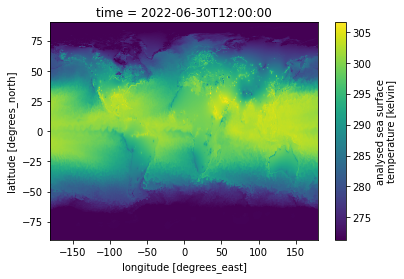

In [27]:
# Read Reference Data
ref_shortname = "CMC0.1deg-CMC-L4-GLOB-v3.0"
ref_s3 = L3.S3List()
granule_urls = ref_s3.login_and_run_query(
    short_name = ref_shortname, 
    provider = provider, 
    temporal_range = temporal_range, 
    bbox = bbox)
granule_urls[0:3]

# Open a tester
test_xr = xr.open_dataset(s3sys.open(granule_urls[0]))

# Plot
test_xr.analysed_sst.isel(time = 0).plot()

### Read L2 Sensor - VIIRS

NOTE: Need to revisit the cleaning datasteps to create a more meaningful dimension than pt to take advantage of xarrays indexing capabilities.

In [36]:
# # Read in L2 Data (pre-processed)
l2_ds = xr.open_dataset("../shared/workflow_data/preprocess/VIIRS_NPP-STAR-L2P-v2.80.nc")
l2_ds#.sea_surface_temperature.plot()


# Clean the dimensions up:

<xarray.Dataset>
Dimensions:                  (pt: 1553042)
Coordinates:
    lat                      (pt) float32 ...
    lon                      (pt) float32 ...
    time                     (pt) datetime64[ns] ...
Dimensions without coordinates: pt
Data variables:
    dt_analysis              (pt) float32 ...
    l2p_flags                (pt) float64 ...
    quality_level            (pt) float32 ...
    sea_surface_temperature  (pt) float32 ...
    sses_bias                (pt) float32 ...
    sses_standard_deviation  (pt) float32 ...
    wind_speed               (pt) float32 ...
Attributes: (12/59)
    geospatial_bounds:                        POLYGON(( -52.706  -0.558,  -46...
    geospatial_first_scanline_first_fov_lat:  33.934265
    geospatial_first_scanline_first_fov_lon:  -46.97821
    geospatial_first_scanline_last_fov_lat:   29.02539
    geospatial_first_scanline_last_fov_lon:   -15.067383
    geospatial_last_scanline_first_fov_lat:   -0.5576172
    ...                                       ...
    time_coverage_start:                      20220718T035000Z
    title:                                    VIIRS L2P SST
    uuid:                                     73084fd4-2aab-11ed-985e-ac1f6b5...
    westernmost_longitude:                    -52.705994
    netcdf_version_id:                        4.7.4 of Nov 18 2021 15:43:53 $
    Conventions:                              Conventions = CF-1.7, ACDD-1.3

% Read in old_bias (i.e. for previous day), today's bias reference (i.e. CMC), today's input observations

obs_bias(nx_b, ny_b) bias_old(nx_b, ny_b) bias_new(nx_b, ny_b) sum_obs(nx_b, ny_b) n_obs(nx_b, ny_b)

smooth_kernel(n_smooth_x, n_smooth_y)

### Bias Correction Workflow:

Modeled off pseudo-code here: https://github.com/gridSST-hackathon/data-pre-processing/blob/andy-jacob/bias_update_psuedocode.md

In [16]:
# Current Date (or any date to use as an index)
date_i = "2021-10-31"
date_i = datetime.strptime(date_i, '%Y-%m-%d')
date_i

TypeError: unsupported operand type(s) for -: 'datetime.datetime' and 'int'

% For example, a simple smooth, but could use a different (e.g. Gaussian) kernel

smooth_kernel(:,:) = 1


In [19]:
# Source: https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
   
def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)



nx_b, ny_b = dimensions of x,y in bias field  (i.e. on 0.1x0.1 degree grid) 
nx, ny = dimensions of x,y in input_datatype (i.e. L2P pixels)

In [ ]:
nx_b, ny_b = bias_ds.dims
nx, ny     = l2_ds.dims

good is a vector of indices for input data that pass QC n_good is the length of the vector

In [ ]:

obs=input_datatype(good)
